In [4]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from tqdm import tqdm
import pickle
import time 

from datetime import datetime
from datetime import timedelta

from create_financial_database import get_credentials 
from SQLite_tools import query_stock_data, check_if_close_price_exists
from ticker_loader import load_SPY_components
from monthly_backtester import organize_lstm_data_as_node_predictions


In [ ]:

models = ["A3TGCN2_1", "A3TGCN2_2", "A3TGCN2_3", "A3TGCN2_4", "A3TGCN2_5", "A3TGCN2_6", "A3TGCN2_7", "LSTM_1", "LSTM_2", "LSTM_3", "LSTM_4"]
pre_fix = "../Data/Results/"


last_netvalues = {}
for model_name in models:
    try:
        last_netvalues[model_name] = {}
        df = pd.read_excel(pre_fix + model_name + "_monthly_portfolio_history_cost0.xlsx")
        last_netvalues[model_name]["Netvalue at 0% cost"] = f"{df['net_value'].iloc[-1]:.2f} %"
        df = pd.read_excel(pre_fix + model_name + "_monthly_portfolio_history_cost8.xlsx")
        last_netvalues[model_name]["Netvalue at 0.08% cost"] = f"{df['net_value'].iloc[-1]:.2f} %"
        df = pd.read_excel(pre_fix + model_name + "_monthly_portfolio_history_cost1.xlsx")
        last_netvalues[model_name]["Netvalue at 1% cost"] = f"{df['net_value'].iloc[-1]:.2f} %"
    except FileNotFoundError:
        print(f"Model {model_name} does not have a netvalue file")
        continue
last_netvalues

df = pd.DataFrame(last_netvalues).T
df

,Netvalue at 0% cost,Netvalue at 0.08% cost,Netvalue at 1% cost
A3TGCN2_1,165.52 %,157.21 %,86.67 %
A3TGCN2_2,151.70 %,144.02 %,79.01 %
A3TGCN2_3,216.23 %,205.36 %,113.14 %
A3TGCN2_4,225.78 %,214.42 %,118.04 %
A3TGCN2_5,290.94 %,277.87 %,163.43 %
A3TGCN2_6,264.17 %,250.83 %,137.81 %
A3TGCN2_7,217.76 %,206.63 %,112.65 %
LSTM_1,202.45 %,194.66 %,123.63 %
LSTM_2,240.82 %,231.55 %,147.08 %
LSTM_3,180.24 %,173.31 %,110.15 %


In [6]:
model_name = "A3TGCN2_5"
# model_name = "LSTM_4"

In [7]:
def load_index_to_ticker_dict():
    """
    Load the index to ticker dictionary
    """
    with open('../Data/Nodes/index_to_ticker.pkl', 'rb') as f:
        index_to_ticker = pickle.load(f)

    with open('../Data/Nodes/ticker_to_index.pkl', 'rb') as f:
        ticker_to_index = pickle.load(f)

    return index_to_ticker, ticker_to_index

index_to_ticker, ticker_to_index = load_index_to_ticker_dict()
for key,val in index_to_ticker.items():
    print(key,val)
    if key >= 10:
        break

0 A
1 AABA
2 AAL
3 AAP
4 AAPL
5 ABBV
6 ABC
7 ABMD
8 ABNB
9 ABT
10 ABX


In [ ]:
def load_results(filename):
    """
    Load the results from the database
    """
    with open(f'../Data/Results/{filename}.pkl', 'rb') as f:
        results = pickle.load(f)
    # print("Dict keys: ", results.keys())
    # print("Learning_Rate", results['Learning_Rate'])

    if "LSTM" in filename:
        pass
        predictions, ground_truth, dates = organize_lstm_data_as_node_predictions(results, ticker_to_index)
        results["Prediction"] = predictions
        results["Ground Truth"] = ground_truth
        results["Test_Dates"] = [date.strftime('%Y-%m-%d') for date in dates]
    else:
        predictions = results["Prediction"]
        ground_truth = results["Ground Truth"]
        results["Test_Dates"] = results["Date"]

    return results


results = load_results(f"{model_name}_results")

print("Length of predictions: ", len(results["Prediction"]))
print("Length of ground truth: ", len(results["Ground Truth"]))
print("Length of test dates: ", len(results["Test_Dates"]))

for idx,(key,val) in enumerate(results.items()):
    print(key, type(val))


Length of predictions:  1422
Length of ground truth:  1422
Length of test dates:  1422
Date <class 'list'>
Prediction <class 'list'>
Ground Truth <class 'list'>
Val_Prediction <class 'list'>
Val_Ground Truth <class 'list'>
Model_Name <class 'str'>
Hidden_Dim <class 'int'>
Periods <class 'int'>
Batch_Size <class 'int'>
Optimizer <class 'str'>
Learning_Rate <class 'float'>
Weight_Decay <class 'int'>
Loss_Function <class 'str'>
Epochs <class 'int'>
Patience <class 'int'>
Train_Loss <class 'list'>
Train_Unweighted_Loss <class 'list'>
Val_Loss <class 'list'>
Val_Unweighted_Loss <class 'list'>
Test_Loss <class 'float'>
Test_Unweighted_Loss <class 'float'>
Test_Dates <class 'list'>


In [ ]:
hyperparameters = {}

for model_name in models:
    hyperparameters[model_name] = {}
    print(f"Model: {model_name}")
    results = load_results(f"{model_name}_results")
    for key,val in results.items():
        if key not in ["Prediction", "Ground Truth", "Test_Dates", "Tickers", "Val_Dates", "Date", "Val_Prediction", "Val_Ground Truth", "Val_Tickers"]:
            hyperparameters[model_name][key] = val
            if key in ["Train_Loss", "Val_Loss","Train_Unweighted_Loss", "Val_Unweighted_Loss"]:
                try:
                    hyperparameters[model_name][key] = val[-1]
                except:
                    hyperparameters[model_name][key] = val

for model_name in models:
    try:
        train_time = hyperparameters[model_name]["Train_Time"]
        if train_time == "N/A":
            continue
        hyperparameters[model_name]["Train_Time"] = str(timedelta(seconds=float(train_time))).split(".")[0]
    except KeyError:
        hyperparameters[model_name]["Train_Time"] = "N/A"

param_df = pd.DataFrame(hyperparameters)
# param_df.loc["Train_Time", "A3TGCN2_3"] = str(timedelta(seconds=float(120))).split(".")[0]
param_df.loc["Train_Time", "A3TGCN2_1"] = str(timedelta(minutes=float(43))).split(".")[0]
param_df.loc["Train_Time", "A3TGCN2_2"] = str(timedelta(minutes=float(116))).split(".")[0]
param_df.loc["Train_Time", "A3TGCN2_3"] = str(timedelta(minutes=float(120))).split(".")[0]
param_df.loc["Train_Time", "A3TGCN2_4"] = str(timedelta(minutes=float(72))).split(".")[0]
param_df.loc["Train_Time", "A3TGCN2_5"] = str(timedelta(minutes=float(531))).split(".")[0]
param_df.loc["Train_Time", "A3TGCN2_6"] = str(timedelta(minutes=float(1192))).split(".")[0]
param_df.loc["Train_Time", "A3TGCN2_7"] = str(timedelta(minutes=float(154))).split(".")[0]


param_df.loc["Forced Epochs", "A3TGCN2_1"] = str(timedelta(minutes=float(43))).split(".")[0]
param_df.loc["Forced Epochs", "A3TGCN2_2"] = str(timedelta(minutes=float(116))).split(".")[0]
param_df.loc["Forced Epochs", "A3TGCN2_3"] = str(timedelta(minutes=float(120))).split(".")[0]
param_df.loc["Forced Epochs", "A3TGCN2_4"] = str(timedelta(minutes=float(72))).split(".")[0]
param_df.loc["Forced Epochs", "A3TGCN2_5"] = 50
param_df.loc["Forced Epochs", "A3TGCN2_6"] = 100
param_df.loc["Forced Epochs", "A3TGCN2_7"] = 10
param_df.loc["Forced Epochs", "LSTM_2"] = 15
param_df.loc["Forced Epochs", "LSTM_3"] = 5
param_df.loc["Forced Epochs", "LSTM_4"] = 10

param_df.loc["Epochs", "A3TGCN2_5"] = 59
param_df.loc["Patience", "A3TGCN2_5"] = 10
param_df.loc["Epochs", "A3TGCN2_6"] = 119
param_df.loc["Epochs", "A3TGCN2_7"] = 119

param_df.loc["Loss_Function_Weights", "A3TGCN2_1"] = "N/A"
param_df.loc["Loss_Function_Weights", "A3TGCN2_2"] = "Weights 1"
param_df.loc["Loss_Function_Weights", "A3TGCN2_3"] = "Weights 2"
param_df.loc["Loss_Function_Weights", "A3TGCN2_4"] = "Weights 2"
param_df.loc["Loss_Function_Weights", "A3TGCN2_5"] = "Weights 2"
param_df.loc["Loss_Function_Weights", "A3TGCN2_6"] = "Weights 2"
param_df.loc["Loss_Function_Weights", "A3TGCN2_7"] = "Weights 2"
param_df.loc["Loss_Function_Weights", "LSTM_1"]    = "Weights 3"
param_df.loc["Loss_Function_Weights", "LSTM_2"]    = "Weights 3"
param_df.loc["Loss_Function_Weights", "LSTM_3"]    = "Weights 4"
param_df.loc["Loss_Function_Weights", "LSTM_4"]    = "Weights 2"

param_df.rename(index={"Gamme (LR Decay)": "Gamma (LR Decay)"}, inplace=True)
param_df.loc["Gamma (LR Decay)", ["A3TGCN2_1","A3TGCN2_2","A3TGCN2_3","A3TGCN2_4","A3TGCN2_5","A3TGCN2_6","A3TGCN2_7", "LSTM_1"]] = 0
param_df.loc["Dropout",                 ["A3TGCN2_2","A3TGCN2_3","A3TGCN2_4","A3TGCN2_5","A3TGCN2_6","A3TGCN2_7"]] = 0
param_df.loc["Loss_Function",           ["A3TGCN2_2","A3TGCN2_3","A3TGCN2_4","A3TGCN2_5","A3TGCN2_6","A3TGCN2_7", "LSTM_1", "LSTM_2", "LSTM_3", "LSTM_4"]] = "Weighted MSE"
param_df.loc["Loss_Function",           "A3TGCN2_1"] = "MSE"

param_df.loc["Num_Layers",           ["A3TGCN2_1","A3TGCN2_2","A3TGCN2_3","A3TGCN2_4","A3TGCN2_5","A3TGCN2_6","A3TGCN2_7"]] = "N/A"
param_df.loc["Dropout",           ["A3TGCN2_1","A3TGCN2_2","A3TGCN2_3","A3TGCN2_4","A3TGCN2_5","A3TGCN2_6","A3TGCN2_7"]] = 0
param_df.loc["Periods",           ["LSTM_1", "LSTM_2", "LSTM_3", "LSTM_4"]] = 5


param_df.drop(index = ["Train_Unweighted_Loss","Weight_Decay"], inplace=True)


param_df.to_excel("../Data/Results/Model_Parameters.xlsx")
param_df

Model: A3TGCN2_1
Model: A3TGCN2_2
Model: A3TGCN2_3
Model: A3TGCN2_4
Model: A3TGCN2_5
Model: A3TGCN2_6
Model: A3TGCN2_7
Model: LSTM_1
Model: LSTM_2
Model: LSTM_3
Model: LSTM_4


,A3TGCN2_1,A3TGCN2_2,A3TGCN2_3,A3TGCN2_4,A3TGCN2_5,A3TGCN2_6,A3TGCN2_7,LSTM_1,LSTM_2,LSTM_3,LSTM_4
Model_Name,A3TGCN2_1,A3TGCN2_2,A3TGCN2_3,A3TGCN2_4,A3TGCN2_5,A3TGCN2_6,A3TGCN2_7,LSTM_1,LSTM_2,LSTM_3,LSTM_4
Hidden_Dim,512,512,512,512,512,512,512,64,64,64,128
Periods,10,3,3,3,5,5,5,5,5,5,5
Batch_Size,1,1,1,1,1,1,1,32,32,32,16
Optimizer,Adam,Adam,Adam,Adam,Adam,Adam,Adam,Adam,Adam,Adam,Adam
Learning_Rate,0.00001000,0.00001000,0.00001000,0.00001000,0.00000100,0.00001000,0.00001000,0.00000100,0.00000011,0.00000011,0.00000000
Loss_Function,MSE,Weighted MSE,Weighted MSE,Weighted MSE,Weighted MSE,Weighted MSE,Weighted MSE,Weighted MSE,Weighted MSE,Weighted MSE,Weighted MSE
Epochs,7,17,14,11,59,119,119,12,22,22,39
Patience,3,5,3,3,10,20,5,4,4,4,4
Train_Loss,1.28529213,1.28137384,4.44585367,4.32584282,4.33372920,4.27494826,4.31740515,6.95941645,6.96774336,6.91040205,6.03115255


1 Day worth of prediction:  734
predictions:  1225780
ground_truth:  1225780 

Confusion Matrix: 
 [[ 11497.  23032.  28153.  19819.  11175.]
 [ 26478.  44624.  46344.  28919.  10078.]
 [ 39831.  61677. 581482.  34270.  11016.]
 [ 25625.  47070.  47309.  29576.  10823.]
 [  8576.  20193.  26382.  19340.  12491.]]


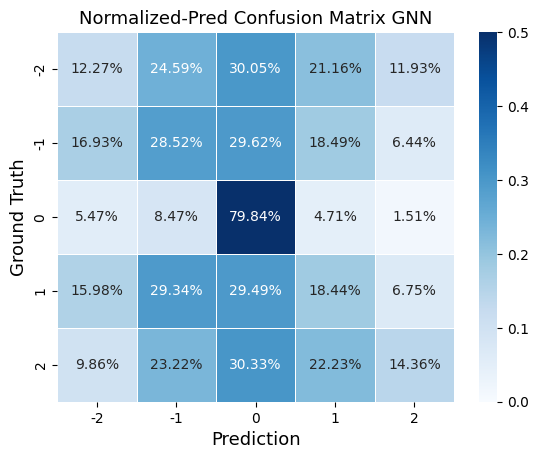

Accuracy: 0.5545
Class -2: Precision=0.1026, Recall=0.1227, F1-Score=0.1118
Class -1: Precision=0.2270, Recall=0.2852, F1-Score=0.2528
Class 0 : Precision=0.7969, Recall=0.7984, F1-Score=0.7977
Class 1 : Precision=0.2242, Recall=0.1844, F1-Score=0.2023
Class 2 : Precision=0.2247, Recall=0.1436, F1-Score=0.1752
Macro Precision: 0.3151
Macro Recall:    0.3069
Macro F1-Score:  0.3080
Macro MSE:       1.7280

Mean Prediction: -0.2737
Max Prediction:  5.3918
Min Prediction:  -4.6144
Std Prediction:  0.9208
Distribution of Labels: (array([-2., -1.,  0.,  1.,  2.]), array([ 93676, 156443, 728276, 160403,  86982], dtype=int64))


{'accuracy': 0.5544795966649807,
 'precision': array([0.10264537, 0.22698326, 0.79691093, 0.22418968, 0.22472698]),
 'recall': array([0.12273154, 0.28524127, 0.79843631, 0.18438558, 0.14360442]),
 'f1_score': array([0.11179339, 0.25279927, 0.79767289, 0.20234874, 0.17523235]),
 'macro_precision': 0.31509124551152484,
 'macro_recall': 0.30687982451784185,
 'macro_f1_score': 0.30796932736950494}

In [ ]:

def evaluation_of_classification(results, normalized = False):
    """
    Evaluate the results as a 5-class classification problem.
    """
    classification_results = {}

    predictions = np.concatenate([value.flatten() for value in results["Prediction"]])
    ground_truth = np.concatenate([value.flatten() for value in results["Ground Truth"]])

    if normalized: 
        pred_shift = np.mean(ground_truth) - np.mean(predictions) 
        pred_scale = np.std(ground_truth) / np.std(predictions)
        predictions = pred_scale * (predictions + pred_shift)
        
    print("1 Day worth of prediction: ", len(results["Prediction"][0]))
    print("predictions: ", len(predictions))
    print("ground_truth: ", len(ground_truth), "\n")

    confusion_matrix = np.zeros((5, 5))
    confusion_matrix_index = {-2: 0, -1: 1, 0: 2, 1: 3, 2: 4}

    for idx, prediction in enumerate(predictions):
        unrounded_prediction = prediction
        prediction = round(prediction)

        if prediction < -2:
            prediction = -2
        elif prediction > 2:
            prediction = 2

        ground_truth_label = round(ground_truth[idx])

        confusion_matrix[confusion_matrix_index[ground_truth_label], confusion_matrix_index[prediction]] += 1

    print("Confusion Matrix: \n", confusion_matrix)
    normalised_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1)[:, None]

    sns.heatmap(
        normalised_confusion_matrix,
        annot=True,
        fmt=".2%",
        cmap="Blues",
        xticklabels=["-2", "-1", "0", "1", "2"],
        yticklabels=["-2", "-1", "0", "1", "2"],
        cbar=True,
        linewidth=0.5,
        annot_kws={"size": 10},
        vmin=0,
        vmax=0.5,
    )
    plt.xlabel("Prediction", fontsize=13)
    plt.ylabel("Ground Truth", fontsize=13)
    if normalized:
        plt.title("Normalized-Pred Confusion Matrix GNN", fontsize=13)
    else:
        plt.title("Confusion Matrix", fontsize=14)

    plt.show()

    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    print(f"Accuracy: {accuracy:.4f}")

    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)

    precision = np.nan_to_num(precision)
    recall = np.nan_to_num(recall)
    f1_score = np.nan_to_num(f1_score)

    for idx, label in enumerate(["-2", "-1", "0", "1", "2"]):
        print(f"Class {label:2}: Precision={precision[idx]:.4f}, Recall={recall[idx]:.4f}, F1-Score={f1_score[idx]:.4f}")

    # Macro-averaged metrics
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = np.mean(f1_score)

    macro_mse = np.mean(np.square(np.subtract(predictions, ground_truth)))
    mean_prediction = np.mean(predictions)
    std_prediction = np.std(predictions)
    distribution_of_labels = np.unique(ground_truth, return_counts=True)



    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall:    {macro_recall:.4f}")
    print(f"Macro F1-Score:  {macro_f1_score:.4f}")
    print(f"Macro MSE:       {macro_mse:.4f}")
    print("")
    print(f"Mean Prediction: {mean_prediction:.4f}")
    print(f"Max Prediction:  {np.max(predictions):.4f}")
    print(f"Min Prediction:  {np.min(predictions):.4f}")
    print(f"Std Prediction:  {std_prediction:.4f}")
    print(f"Distribution of Labels: {distribution_of_labels}")

    classification_results["accuracy"] = accuracy
    classification_results["precision"] = precision
    classification_results["recall"] = recall
    classification_results["f1_score"] = f1_score
    classification_results["macro_precision"] = macro_precision
    classification_results["macro_recall"] = macro_recall
    classification_results["macro_f1_score"] = macro_f1_score

    return classification_results

evaluation_of_classification(results, normalized=True)

1 Day worth of prediction:  734
predictions:  1225780
ground_truth:  1225780 

Confusion Matrix: 
 [[     0.      0.  93676.      0.      0.]
 [     0.      0. 156443.      0.      0.]
 [     0.      0. 728276.      0.      0.]
 [     0.      0. 160403.      0.      0.]
 [     0.      0.  86982.      0.      0.]]


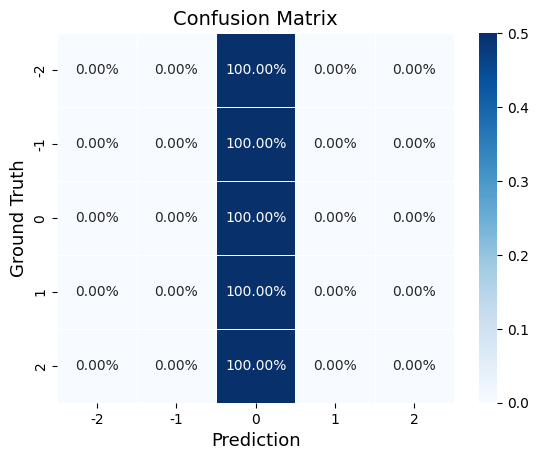

Accuracy: 0.5941
Class -2: Precision=0.0000, Recall=0.0000, F1-Score=0.0000
Class -1: Precision=0.0000, Recall=0.0000, F1-Score=0.0000
Class 0 : Precision=0.5941, Recall=1.0000, F1-Score=0.7454
Class 1 : Precision=0.0000, Recall=0.0000, F1-Score=0.0000
Class 2 : Precision=0.0000, Recall=0.0000, F1-Score=0.0000
Macro Precision: 0.1188
Macro Recall:    0.2000
Macro F1-Score:  0.1491
Macro MSE:       0.8476

Mean Prediction: 0.0007
Max Prediction:  0.1599
Min Prediction:  -0.1213
Std Prediction:  0.0259
Distribution of Labels: (array([-2., -1.,  0.,  1.,  2.]), array([ 93676, 156443, 728276, 160403,  86982], dtype=int64))


C:\Users\emilh\AppData\Local\Temp\ipykernel_17900\1551900816.py:75: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)


{'accuracy': 0.5941327154954397,
 'precision': array([0.        , 0.        , 0.59413272, 0.        , 0.        ]),
 'recall': array([0., 0., 1., 0., 0.]),
 'f1_score': array([0.        , 0.        , 0.74539931, 0.        , 0.        ]),
 'macro_precision': 0.11882654309908794,
 'macro_recall': 0.2,
 'macro_f1_score': 0.14907986260373296}

In [9]:
evaluation_of_classification(results, normalized=False)

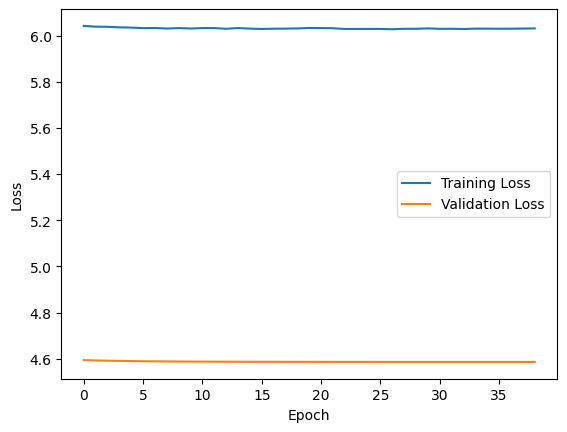

In [ ]:
plt.plot(results["Train_Loss"], label="Training Loss")
plt.plot(results["Val_Loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

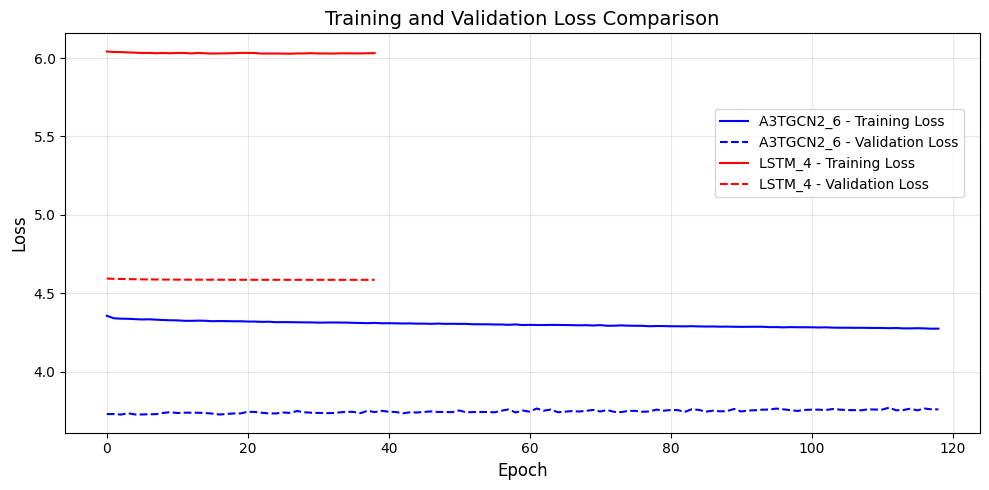

In [ ]:
def plot_loss_curves(results_model1, results_model2, output_file="loss_curves_comparison.png"):
    """
    Plots the training and validation loss for two machine learning models on the same plot.

    Parameters:
        results_model1 (dict): A dictionary containing "Train_Loss" and "Val_Loss" for Model 1.
        results_model2 (dict): A dictionary containing "Train_Loss" and "Val_Loss" for Model 2.
        output_file (str): The file name to save the plot.

    Returns:
        None
    """
    plt.figure(figsize=(10, 5))  

    plt.plot(results_model1["Train_Loss"], label="A3TGCN2_6 - Training Loss", linestyle='-', color='blue')
    plt.plot(results_model1["Val_Loss"], label="A3TGCN2_6 - Validation Loss", linestyle='--', color='blue')


    plt.plot(results_model2["Train_Loss"], label="LSTM_4 - Training Loss", linestyle='-', color='red')
    plt.plot(results_model2["Val_Loss"], label="LSTM_4 - Validation Loss", linestyle='--', color='red')


    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training and Validation Loss Comparison", fontsize=14)
    plt.legend(fontsize=10, loc="right", bbox_to_anchor=(0.99, 0.7))

    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

results_model1 = load_results(f"A3TGCN2_6_results")
results_model2 = load_results(f"LSTM_4_results")
plot_loss_curves(results_model1, results_model2)


In [ ]:
def get_predictions_for_1_day(date, results, index_to_ticker):
    """
    Retrieve predictions for the two weeks prior to the start of the month.

    Parameters:
        all_dates       (list): All dates from the results dictionary.
        all_predictions (list): List of prediction arrays corresponding to all dates.
        index_to_ticker (dict): Mapping of indices to stock tickers.

    Returns:
        dict: Dictionary mapping tickers to their averaged predictions for the two weeks prior.
    """

    predictions = {}
    all_dates = results["Test_Dates"]
    all_predictions = results["Prediction"]

    pred_idx = all_dates.index(date)
    prediction_values = all_predictions[pred_idx]
    for node_idx, pred in enumerate(prediction_values):
        ticker = index_to_ticker[node_idx]
        label = results["Ground Truth"][pred_idx][node_idx]
        predictions[ticker] = {"prediction": pred, "target": label}

    predictions = dict(sorted(predictions.items(), key=lambda item: item[1]["prediction"], reverse=True))

    return predictions


date_of_example = "2021-06-04"
daily_predictions = get_predictions_for_1_day(date_of_example, results, index_to_ticker)

print("Date of example prediction: ", date_of_example)
for idx, (ticker, val) in enumerate(daily_predictions.items()):
    print(f"{idx+1:2}: {ticker:5}  prediction: {val['prediction']:.4f}  target: {val['target']:.0f}")
    if idx >= 20:
        break

Date of example prediction:  2021-06-04
 1: HPQ    prediction: 0.0682  target: -1
 2: ROL    prediction: 0.0618  target: 0
 3: CTXS   prediction: 0.0586  target: 0
 4: GPS    prediction: 0.0575  target: 1
 5: DLTR   prediction: 0.0572  target: 0
 6: PAYC   prediction: 0.0536  target: 2
 7: HOLX   prediction: 0.0518  target: 1
 8: DISCA  prediction: 0.0482  target: -1
 9: MCK    prediction: 0.0481  target: 0
10: AZO    prediction: 0.0454  target: 0
11: VFC    prediction: 0.0444  target: 1
12: ABT    prediction: 0.0436  target: 0
13: KMX    prediction: 0.0428  target: 1
14: TPR    prediction: 0.0405  target: 1
15: RL     prediction: 0.0404  target: 1
16: MHK    prediction: 0.0402  target: -2
17: ENPH   prediction: 0.0401  target: 2
18: TYL    prediction: 0.0398  target: 2
19: STE    prediction: 0.0377  target: 1
20: COG    prediction: 0.0371  target: 1
21: TJX    prediction: 0.0371  target: 0


In [13]:
results.keys()

dict_keys(['Test_Dates', 'Prediction', 'Ground Truth', 'Tickers', 'Val_Dates', 'Val_Prediction', 'Val_Ground Truth', 'Val_Tickers', 'Model_Name', 'Hidden_Dim', 'Num_Layers', 'Batch_Size', 'Optimizer', 'Learning_Rate', 'Gamme (LR Decay)', 'Loss_Function', 'Loss_Function_Weights', 'Dropout', 'Epochs', 'Train_Time', 'Patience', 'Train_Loss', 'Train_Unweighted_Loss', 'Val_Loss', 'Val_Unweighted_Loss', 'Test_Loss', 'Test_Unweighted_Loss'])

In [14]:
active_stocks   = query_stock_data(table="Active_Stocks", start_date=results["Test_Dates"][0], end_date=results["Test_Dates"][-1], ticker="all_stocks")
active_stocks = active_stocks[active_stocks["Active"] == 1]
active_stocks_dict = {}
for idx, row in tqdm(active_stocks.iterrows(), total=len(active_stocks)):
    if row["Date"] not in active_stocks_dict:
        active_stocks_dict[row["Date"]] = {}
    active_stocks_dict[row["Date"]][row["Ticker"]] = row["Active"]

100%|██████████| 705430/705430 [00:29<00:00, 24015.46it/s]


In [ ]:

def prediction_accuracy(results, index_to_ticker, top_k=20, active_stocks_dict=None, verbose=False):
    """
    Create a confusion matrix for the daily predictions.

    Parameters:
        results         (dict): Results dictionary.
        index_to_ticker (dict): Mapping of indices to stock tickers.

    Returns:
        np.ndarray: Confusion matrix.
    """

    tmp_ground_truth = np.concatenate([value.flatten() for value in results["Ground Truth"]])
    tmp_predictions = np.concatenate([value.flatten() for value in results["Prediction"]])

    total_amount_of_stocks_in_testset = len(active_stocks["Ticker"].unique())
    print("Mean of the Target:", np.mean(tmp_ground_truth), " and Predictions:", np.mean(tmp_predictions))
    print("Std  of the Target:", np.std(tmp_ground_truth), " and Predictions:", np.std(tmp_predictions))
    if "LSTM" in results["Model_Name"]:
        print("Proportion of labels 1&2: ", np.sum(tmp_ground_truth >= 1)  / len(active_stocks))
    print("")

    accuracy_dict = {}

    if type(top_k) == int:
        top_k_list = range(1, top_k+1)
    else:
        top_k_list = top_k
        
    for local_top_k in top_k_list:

        num_predictions = 0
        num_correct_predictions = 0

        for date in results["Test_Dates"]:
            predictions = get_predictions_for_1_day(date, results, index_to_ticker)
            for idx, (ticker, value) in enumerate(predictions.items()):
                if idx < local_top_k:
                    prediction = value["prediction"] # This definition is just for readability of the code, as using the target value directly is intended.
                    ground_truth = value["target"]
                    
                    if date in active_stocks_dict:
                        if ticker in active_stocks_dict[date]:
                            if ground_truth in [1,2]:
                                num_correct_predictions += 1
                            num_predictions += 1

        accuracy = num_correct_predictions / num_predictions
        print(f"Constructing a portfolio of {local_top_k} stocks, yields an accuracy: {100*accuracy:.4f}% of selecting stocks with a label of 1 or 2.")
        accuracy_dict[local_top_k] = accuracy

    return accuracy_dict


print(results["Model_Name"])
prediction_accuracy(results, index_to_ticker, top_k=5, active_stocks_dict=active_stocks_dict)

LSTM_4
Mean of the Target: -0.0076914291308391395  and Predictions: 0.0006871229327543964
Std  of the Target: 0.9208443688719261  and Predictions: 0.025876854014337248
Proportion of labels 1&2:  0.3506868151340317

Constructing a portfolio of 1 stocks, yields an accuracy: 40.3006% of selecting stocks with a label of 1 or 2.
Constructing a portfolio of 2 stocks, yields an accuracy: 40.4651% of selecting stocks with a label of 1 or 2.
Constructing a portfolio of 3 stocks, yields an accuracy: 39.8665% of selecting stocks with a label of 1 or 2.
Constructing a portfolio of 4 stocks, yields an accuracy: 39.4064% of selecting stocks with a label of 1 or 2.
Constructing a portfolio of 5 stocks, yields an accuracy: 39.0303% of selecting stocks with a label of 1 or 2.


{1: 0.4030064423765211,
 2: 0.4046511627906977,
 3: 0.3986647591797806,
 4: 0.3940640085821563,
 5: 0.39030320366132726}

# Explore Backtester Results

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm


def plot_histogram_with_statistics(data, column_name, x_axis_label, bins=None):
    """
    Plots a histogram with detailed statistics and a normal distribution curve.

    Parameters:
    - data: pandas DataFrame containing the dataset.
    - column_name: str, name of the column to plot the histogram for.
    - x_axis_label: str, label for the x-axis.
    """
    column_data = data[column_name].dropna()

    mean = column_data.mean()
    std_dev = column_data.std()
    min_val = column_data.min()
    max_val = column_data.max()
    percentile_25 = np.percentile(column_data, 25)
    median = np.median(column_data)
    percentile_75 = np.percentile(column_data, 75)

    # Creating an estimated normal distribution curve (needs finetuning for different datasets)
    x = np.linspace(min_val, max_val, 1000)
    y = norm.pdf(x, mean, std_dev) * len(column_data) * (15 / 45)  
    plt.figure(figsize=(12, 8))

    min_range, max_range = min_val, max_val
    if bins is None:
        bins = int((max_range-min_range)*2)
        if bins > 100:
            bins = 100
        elif bins < 10:
            bins = 10

    # print("min_range: ", min_range)
    # print("max_range: ", max_range)
    # print("bins: ", bins)

    counts, bins, patches = plt.hist(column_data, bins=bins, range=(min_range, max_range), color='skyblue', edgecolor='black', label='Histogram')

    plt.plot(x, y, 'r-', label='Normal Curve')
    plt.axvline(mean, color='red', linestyle='dotted', linewidth=1, label='Mean')
    plt.axvline(mean - std_dev, color='black', linestyle='dotted', linewidth=1, label='1 Std Dev')
    plt.axvline(mean + std_dev, color='black', linestyle='dotted', linewidth=1)

    plt.xlabel(x_axis_label)
    plt.ylabel('Frequency')
    plt.title(f'Histogram with Normal Distribution Curve for "{column_name}"')
    plt.legend(loc='upper left')

    stats_text = (
        f"Mean: {mean:.2f}   Std Dev: {std_dev:.2f}\n \n"
        f"Max: {max_val:.2f}\n"
        f"75th Percentile: {percentile_75:.2f}\n"
        f"Median: {median:.2f}\n"
        f"25th Percentile: {percentile_25:.2f}\n"
        f"Min: {min_val:.2f}"
    )
    plt.text(0.98, 0.98, stats_text, fontsize=10, transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

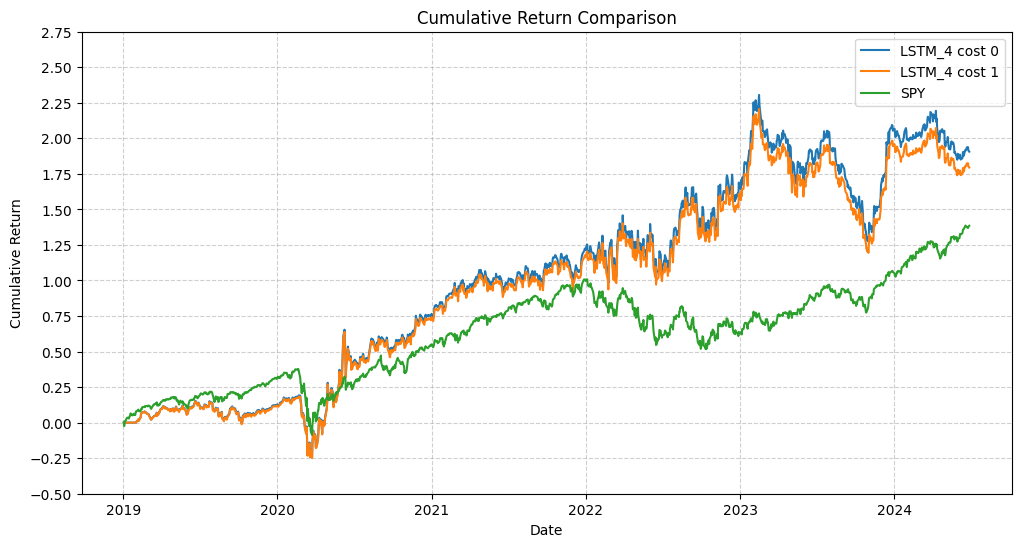

,Metric,LSTM_4 cost 0%,LSTM_4 cost 1%,SPY
0,Cumulative Return %,190.62300000,179.41500000,138.48300000
1,Annualized Return %,21.49200000,20.62300000,17.18600000
2,Annualized Std %,30.60000000,30.60900000,20.28400000
3,Max Drawdown %,-36.59500000,-36.59500000,-33.71700000
4,Sharpe Ratio,0.60400000,0.57600000,0.69900000


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def financial_metrics(daily_returns, risk_free_rate=0.02, trading_days=252):
    """
    Calculate financial metrics from daily returns.

    Parameters:
    - daily_returns: List or numpy array of daily returns.
    - risk_free_rate: Annual risk-free rate, default is 2% (0.02).
    - trading_days: Number of trading days in a year, default is 252.

    Returns:
    - A dictionary containing annualized returns, standard deviation of annualized returns,
      maximum drawdown, and Sharpe ratio.
    """
    daily_returns = np.array(daily_returns)

    cumulative_return = np.prod(1 + daily_returns) - 1
    cumulative_return_list = np.cumprod(1 + daily_returns) - 1

    annualized_return = (1 + cumulative_return) ** (trading_days / len(daily_returns)) - 1

    daily_std = np.std(daily_returns, ddof=1)
    annualized_std = daily_std * np.sqrt(trading_days)

    cumulative_returns = np.cumprod(1 + daily_returns)
    drawdowns = cumulative_returns / np.maximum.accumulate(cumulative_returns) - 1
    max_drawdown = drawdowns.min()

    excess_return = annualized_return - risk_free_rate

    sharpe_ratio = excess_return / annualized_std if annualized_std != 0 else np.nan

    return {
        "Cumulative Return": cumulative_return_list,
        "Annualized Return": annualized_return,
        "Annualized Std": annualized_std,
        "Maximum Drawdown": max_drawdown,
        "Sharpe Ratio": sharpe_ratio
    }



def calculate_financial_ratios_and_compare(model_name, start_date, end_date, trading_days = 252, risk_free_rate = 0.03):
    """
    Calculate financial ratios and compare the performance of SPY with the GNN model (AT-GCN).

    Parameters:
    - daily_history: DataFrame containing "Date", "Returns (%)", "Previous Portfolio Value (USD)",
                        "Portfolio Value (USD)", "Portfolio Composition".

    Returns:
    - A dictionary containing financial ratios and performance comparison.
    """

    daily_history_df0  = pd.read_excel(f"../Data/Results/{model_name}_daily_portfolio_history_cost0.xlsx")
    daily_history_df0 = daily_history_df0[(daily_history_df0['Date'] >= start_date) & (daily_history_df0['Date'] <= end_date)]

    daily_history_df1  = pd.read_excel(f"../Data/Results/{model_name}_daily_portfolio_history_cost8.xlsx")
    daily_history_df1 = daily_history_df1[(daily_history_df1['Date'] >= start_date) & (daily_history_df1['Date'] <= end_date)]

    spy_df = query_stock_data(table="Price_Data", ticker="SPY", start_date=daily_history_df0['Date'].min(), end_date=daily_history_df0['Date'].max())

    daily_history_df0['Date'] = pd.to_datetime(daily_history_df0['Date'])
    daily_history_df1['Date'] = pd.to_datetime(daily_history_df1['Date'])
    spy_df['Date'] = pd.to_datetime(spy_df['Date'])
    merged_df = pd.merge(daily_history_df0, spy_df, on='Date', how='inner')
    merged_df = merged_df.rename(columns={'Returns (%)': f'{model_name} Returns (%) cost 0', 'Close': 'SPY Close'})
    merged_df = pd.merge(daily_history_df1, merged_df, on='Date', how='inner')
    merged_df = merged_df.rename(columns={'Returns (%)': f'{model_name} Returns (%) cost 1'})

    merged_df['SPY Returns (%)'] = merged_df['SPY Close'].pct_change()
    merged_df.loc[0,'SPY Returns (%)'] = 0
    
    model_financial_metrics0 = financial_metrics(merged_df[f'{model_name} Returns (%) cost 0'], risk_free_rate=risk_free_rate, trading_days=trading_days)
    model_financial_metrics1 = financial_metrics(merged_df[f'{model_name} Returns (%) cost 1'], risk_free_rate=risk_free_rate, trading_days=trading_days)
    spy_financial_metrics   = financial_metrics(merged_df['SPY Returns (%)'], risk_free_rate=risk_free_rate, trading_days=trading_days)

    merged_df[f'{model_name} Cumulative Return cost 0'] =  model_financial_metrics0['Cumulative Return']
    merged_df[f'{model_name} Cumulative Return cost 1'] =  model_financial_metrics1['Cumulative Return']
    merged_df['SPY Cumulative Return']    =  spy_financial_metrics['Cumulative Return']

    performance_comparison = pd.DataFrame({
        'Metric': ['Cumulative Return %','Annualized Return %', "Annualized Std %", 'Max Drawdown %','Sharpe Ratio'],
        f'{model_name} cost 0%': [model_financial_metrics0["Cumulative Return"][-1]*100,model_financial_metrics0["Annualized Return"]*100, 
                    model_financial_metrics0["Annualized Std"]*100, 
                    model_financial_metrics0["Maximum Drawdown"]*100, model_financial_metrics0["Sharpe Ratio"]],
        f'{model_name} cost 1%': [model_financial_metrics1["Cumulative Return"][-1]*100,model_financial_metrics1["Annualized Return"]*100, 
                    model_financial_metrics1["Annualized Std"]*100, 
                    model_financial_metrics1["Maximum Drawdown"]*100, model_financial_metrics1["Sharpe Ratio"]],
        'SPY': [spy_financial_metrics["Cumulative Return"][-1]*100, spy_financial_metrics["Annualized Return"]*100, 
                spy_financial_metrics["Annualized Std"]*100,
                spy_financial_metrics["Maximum Drawdown"]*100, spy_financial_metrics["Sharpe Ratio"]]
    })
    performance_comparison = performance_comparison.round(3)

    plt.figure(figsize=(12, 6))
    # plt.plot(merged_df['Date'], merged_df['AT-GCN Portfolio Value'], label='AT-GCN')
    plt.plot(merged_df['Date'], merged_df[f'{model_name} Cumulative Return cost 0'], label=f'{model_name} cost 0')
    plt.plot(merged_df['Date'], merged_df[f'{model_name} Cumulative Return cost 1'], label=f'{model_name} cost 1')
    plt.plot(merged_df['Date'], merged_df['SPY Cumulative Return'], label='SPY')
    plt.title('Cumulative Return Comparison')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.yticks(np.arange(-0.5, 3, 0.25))
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

    return performance_comparison


# model_name = "A3TGCN2_5"
model_name = "LSTM_4"
results = load_results(f"{model_name}_results")

start_date = "2018-11-05"
end_date = "2024-06-29"

performance_table = calculate_financial_ratios_and_compare(model_name, start_date, end_date)
performance_table

In [61]:

daily_history  = pd.read_excel(f"../Data/Results/{model_name}_daily_portfolio_history_cost0.xlsx")
monthly_history = pd.read_excel(f"../Data/Results/{model_name}_monthly_portfolio_history_cost0.xlsx")

monthly_history

,date_of_prediction,start_date,end_date,net_value,amount_of_stocks,cash_holding,portfolio,individual_ticker_pct_change,net_value_%_increase
0,2018-12-31,2019-01-01,2019-01-31,100.00000000,0,1,{'cash': 1.0},"[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {...",0.00000000
1,2019-01-31,2019-02-01,2019-02-28,106.01889764,15,0,"{'ADS': 0.06526873267467101, 'CAG': 0.08047996...","[{'ADS': {'pct_change': -0.033756341968390904,...",6.01889764
2,2019-02-28,2019-03-01,2019-03-30,109.07616096,15,0,"{'AAP': 0.052915803199481276, 'ABBV': 0.113249...","[{'AAP': {'pct_change': 0.038184956303768905, ...",2.88369658
3,2019-03-30,2019-04-01,2019-04-30,109.43964800,15,0,"{'ATVI': 0.05809692643741202, 'CPRI': 0.049765...","[{'ATVI': {'pct_change': 0.035201296651167314,...",0.33324150
4,2019-04-30,2019-05-01,2019-05-31,105.81786771,15,0,"{'ABMD': 0.06282046357034345, 'BIIB': 0.102403...","[{'ABMD': {'pct_change': 0.009075032076510461,...",-3.30938591
...,...,...,...,...,...,...,...,...,...
62,2024-02-29,2024-03-01,2024-03-30,318.28505295,15,0,"{'ADM': 0.1008304426678632, 'APA': 0.052404927...","[{'ADM': {'pct_change': 0.17417933616344392, '...",5.15260540
63,2024-03-30,2024-04-01,2024-04-30,295.86791178,15,0,"{'AKAM': 0.06810576304451763, 'BWA': 0.0686981...","[{'AKAM': {'pct_change': -0.07861681463379609,...",-7.04310208
64,2024-04-30,2024-05-01,2024-05-31,289.14095247,15,0,"{'ACN': 0.06456643492896656, 'CBOE': 0.0584410...","[{'ACN': {'pct_change': -0.07291187501437818, ...",-2.27363598
65,2024-05-31,2024-06-01,2024-06-28,292.36688585,15,0,"{'ADSK': 0.061408313042348124, 'AON': 0.068203...","[{'ADSK': {'pct_change': 0.10562823715284472, ...",1.11569577


In [12]:
daily_history[100:120]

,Date,Returns (%),Previous Portfolio Value (USD),Portfolio Value (USD),Portfolio % Increase
100,2019-04-30,-0.01041995,115.63275304,114.42786509,-1.04199538
101,2019-05-01,-0.00246916,114.42786509,114.14532414,-0.24691621
102,2019-05-02,-0.00317653,114.14532414,113.78273793,-0.31765315
103,2019-05-03,0.00787945,113.78273793,114.67928368,0.78794531
104,2019-05-06,0.02203235,114.67928368,117.20593803,2.20323521
105,2019-05-07,-0.01576122,117.20593803,115.35862902,-1.57612237
106,2019-05-08,0.00785232,115.35862902,116.26446167,0.78523181
107,2019-05-09,-0.00355500,116.26446167,115.85114098,-0.35550046
108,2019-05-10,0.00325012,115.85114098,116.22767116,0.32501206
109,2019-05-13,-0.00532820,116.22767116,115.60838654,-0.53282029


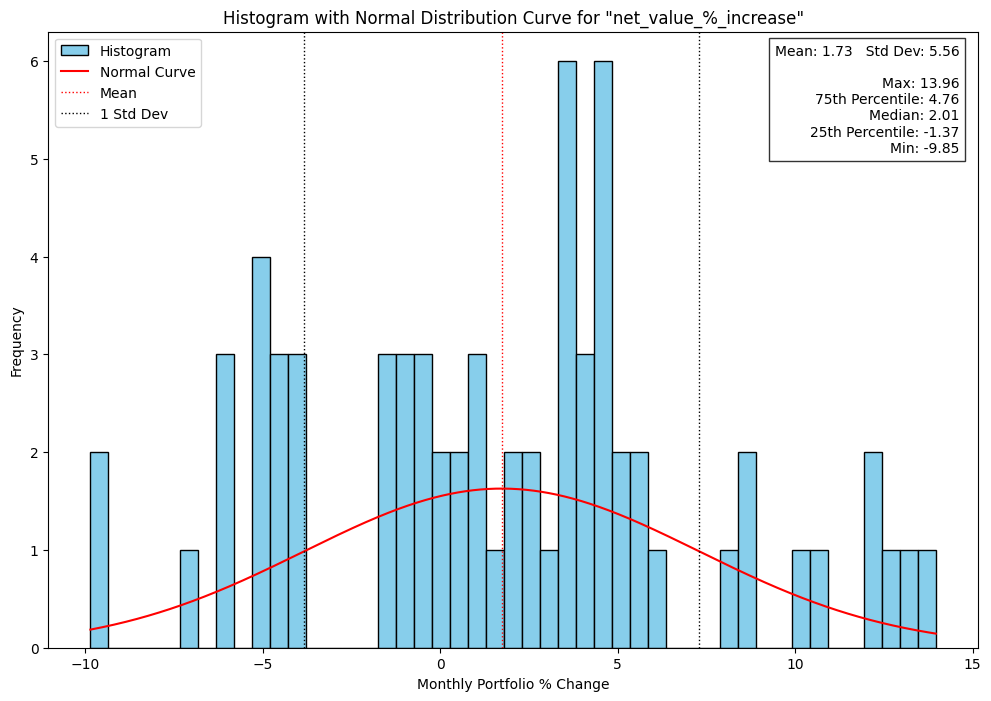

In [ ]:
monthly_history = pd.read_excel(f"../Data/Results/{model_name}_monthly_portfolio_history_cost0.xlsx")

plot_histogram_with_statistics(monthly_history, "net_value_%_increase", "Monthly Portfolio % Change")

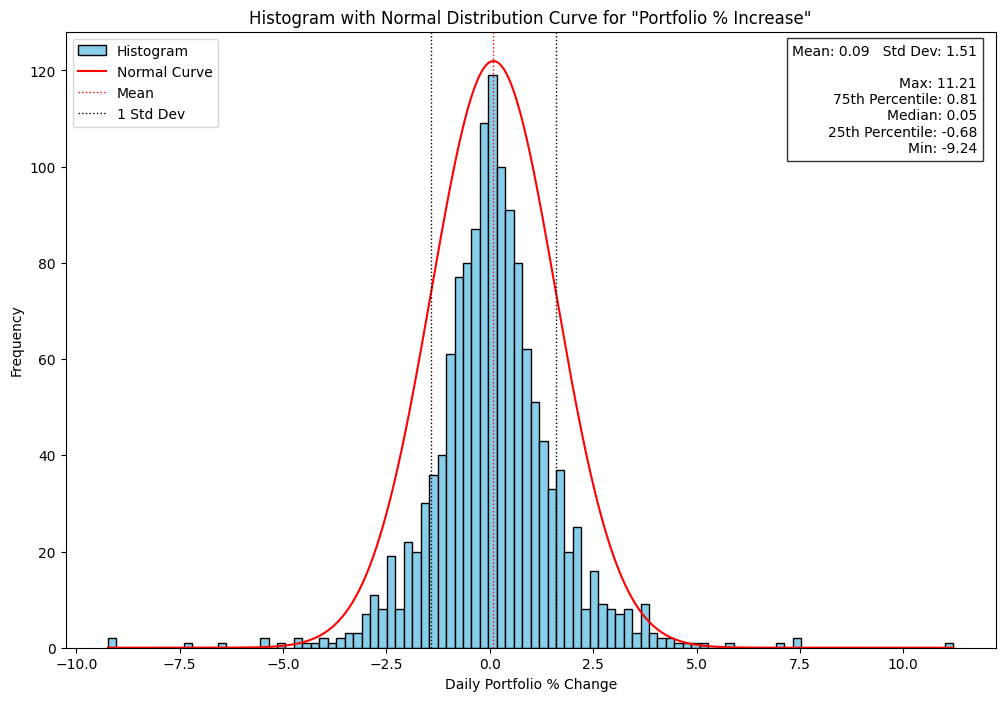

In [ ]:
daily_history  = pd.read_excel(f"../Data/Results/{model_name}_daily_portfolio_history_cost0.xlsx")
local_daily_history = daily_history.copy(deep=True)
local_daily_history = local_daily_history[local_daily_history['Portfolio % Increase'] != 0]

plot_histogram_with_statistics(local_daily_history, "Portfolio % Increase", "Daily Portfolio % Change", bins = 100)

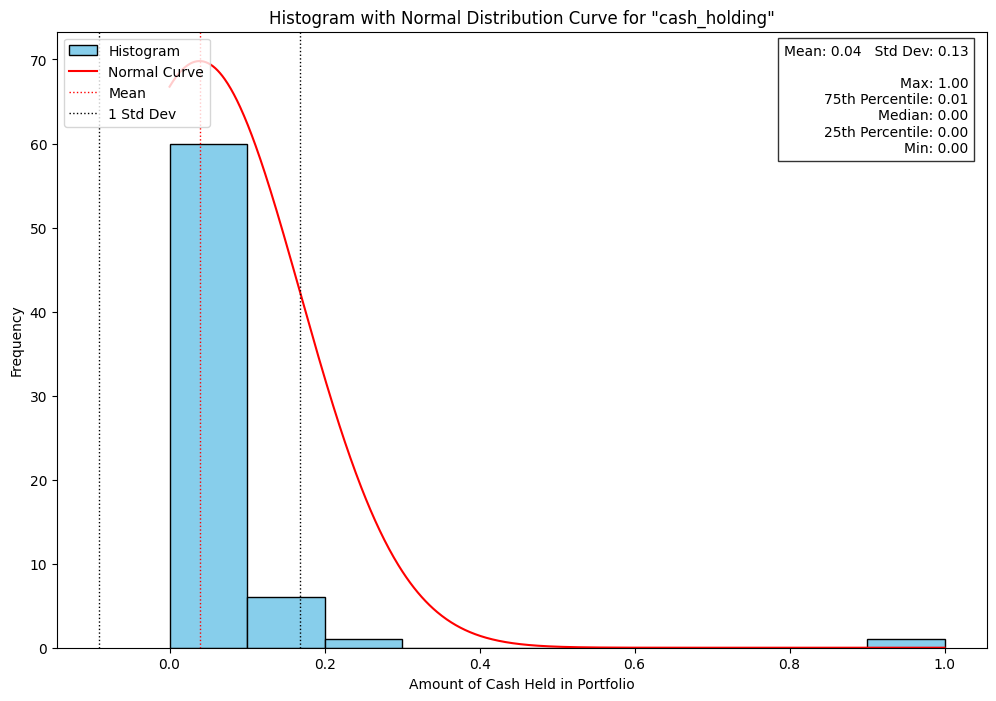

In [ ]:
monthly_history = pd.read_excel(f"../Data/Results/{model_name}_monthly_portfolio_history_cost0.xlsx")

plot_histogram_with_statistics(monthly_history, "cash_holding", "Amount of Cash Held in Portfolio")

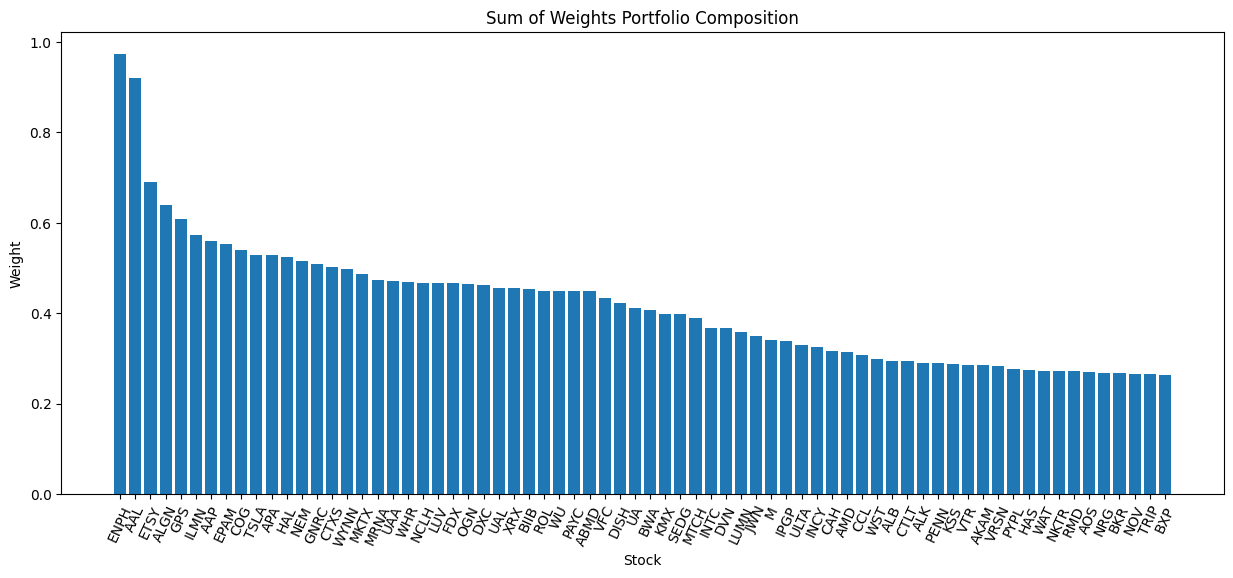

In [ ]:
weights = []
stocks  = []

for idx, row in monthly_history.iterrows():
    portfolio = eval(row["portfolio"])
    for stock,weight in portfolio.items():
        stocks.append(stock)
        weights.append(portfolio[stock])

portfolio_df = pd.DataFrame({"Stock": stocks, "Weight": weights})
portfolio_df = portfolio_df.groupby("Stock").sum().reset_index()
portfolio_df = portfolio_df.sort_values("Weight", ascending=False)

portfolio_df = portfolio_df[portfolio_df["Stock"] != "cash"]

plt.figure(figsize=(15, 6))
plt.bar(portfolio_df.head(70)["Stock"], portfolio_df.head(70)["Weight"])
plt.title("Sum of Weights Portfolio Composition")
plt.xlabel("Stock")
plt.ylabel("Weight")
plt.xticks(rotation=65)
plt.show()


In [ ]:
top_20_tickers = ["SMCI","NVDA","ENPH","BLDR","ANF","KLAC","LLY","TSLA","AVGO","AMD","PWR","LRCX","FICO","DECK","DDS","AMAT","MPWR","GME","CDNS","CMG"]
portfolio_df.reset_index(drop=True, inplace=True)

for pop_ticker in top_20_tickers:
    if pop_ticker in portfolio_df["Stock"].values:
        print(f"{pop_ticker} {portfolio_df[portfolio_df['Stock'] == pop_ticker]['Weight'].values[0] / 68 * 15}")
    else:
        print(f"{pop_ticker} 0")


SMCI 0
NVDA 0.03078678206163342
ENPH 0.21464756966669213
BLDR 0
ANF 0
KLAC 0
LLY 0.04150931809899399
TSLA 0.11664185222810144
AVGO 0
AMD 0.0691664131752311
PWR 0
LRCX 0
FICO 0
DECK 0
DDS 0
AMAT 0
MPWR 0.025151880158807136
GME 0
CDNS 0.05024275291292166
CMG 0.013250488739580644


Number of months in the portfolio:  68


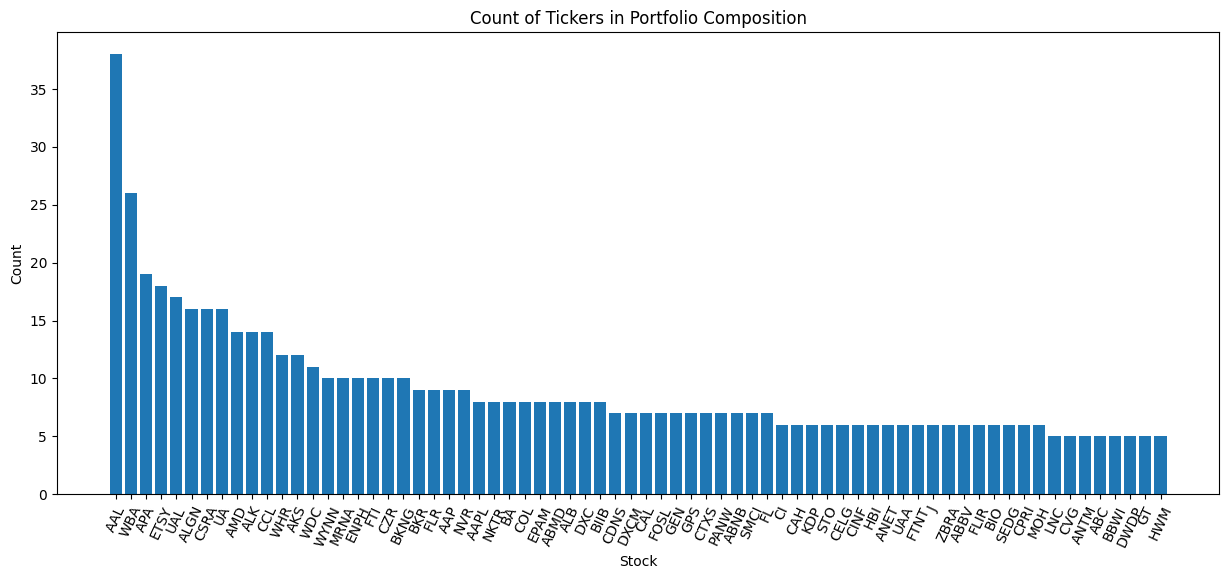

In [ ]:
stock_counts = {}
months_count = 0

for idx, row in monthly_history.iterrows():
    months_count += 1
    portfolio = eval(row["portfolio"])
    for stock,weight in portfolio.items():
        if stock not in stock_counts:
            stock_counts[stock] = 1
        else:
            stock_counts[stock] += 1
portfolio_df = pd.DataFrame({"Stock": list(stock_counts.keys()), "Count": list(stock_counts.values())})
portfolio_df = portfolio_df.sort_values("Count", ascending=False)
portfolio_df = portfolio_df[portfolio_df["Stock"] != "cash"]

print("Number of months in the portfolio: ", months_count)

plt.figure(figsize=(15, 6))
plt.bar(portfolio_df.head(70)["Stock"], portfolio_df.head(70)["Count"])
plt.title("Count of Tickers in Portfolio Composition")
plt.xlabel("Stock")
plt.ylabel("Count")
plt.xticks(rotation=65)
plt.show()


In [50]:
top_20_tickers = ["SMCI","NVDA","ENPH","BLDR","ANF","KLAC","LLY","TSLA","AVGO","AMD","PWR","LRCX","FICO","DECK","DDS","AMAT","MPWR","GME","CDNS","CMG"]
portfolio_df.reset_index(drop=True, inplace=True)

for pop_ticker in top_20_tickers:
    if pop_ticker in portfolio_df["Stock"].values:
        print(f"Ticker: {pop_ticker} is in the portfolio {portfolio_df[portfolio_df['Stock'] == pop_ticker]['Count'].values[0]} times")
    else:
        print(f"Ticker: {pop_ticker} is not in the portfolio.")

Ticker: SMCI is in the portfolio 7 times
Ticker: NVDA is in the portfolio 4 times
Ticker: ENPH is in the portfolio 10 times
Ticker: BLDR is in the portfolio 1 times
Ticker: ANF is in the portfolio 1 times
Ticker: KLAC is not in the portfolio.
Ticker: LLY is in the portfolio 1 times
Ticker: TSLA is in the portfolio 4 times
Ticker: AVGO is in the portfolio 1 times
Ticker: AMD is in the portfolio 14 times
Ticker: PWR is not in the portfolio.
Ticker: LRCX is in the portfolio 1 times
Ticker: FICO is in the portfolio 2 times
Ticker: DECK is in the portfolio 1 times
Ticker: DDS is in the portfolio 3 times
Ticker: AMAT is in the portfolio 3 times
Ticker: MPWR is not in the portfolio.
Ticker: GME is in the portfolio 2 times
Ticker: CDNS is in the portfolio 7 times
Ticker: CMG is not in the portfolio.


Querying Target Data:   0%|          | 0/20 [00:00<?, ?it/s]

Number of months in the portfolio:  67


Querying Target Data:  65%|██████▌   | 13/20 [00:08<00:04,  1.52it/s]C:\Users\emilh\AppData\Local\Temp\ipykernel_16540\3794542504.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(data["target"] >= 1) / len(data)
Querying Target Data: 100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


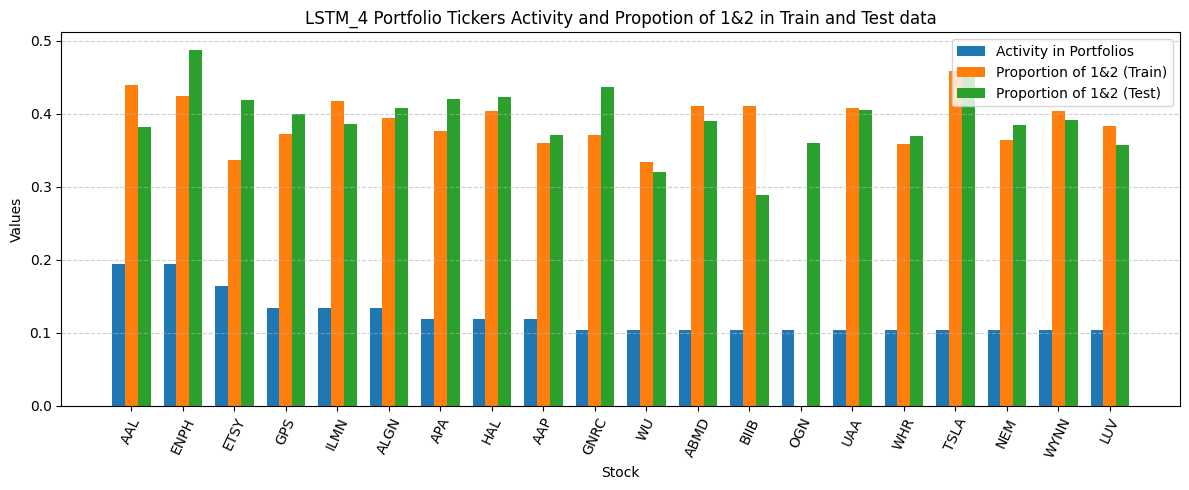

In [ ]:
model_name = "LSTM_4"
# model_name = "A3TGCN2_5"
results = load_results(f"{model_name}_results")
monthly_history = pd.read_excel(f"../Data/Results/{model_name}_monthly_portfolio_history_cost0.xlsx")

def query_stock_target(ticker, start_date, end_date):
    """ Query the target values for a stock within a date range """
    data = query_stock_data(table="Target_Data", ticker=ticker, start_date=start_date, end_date=end_date)
    data = data[data["Pct_Change"]!= 0]
    # return data["target"].mean()
    return np.sum(data["target"] >= 1) / len(data)

stock_counts = {}
months_count = 0

for idx, row in monthly_history.iterrows():
    months_count += 1
    portfolio = eval(row["portfolio"])
    for stock, weight in portfolio.items():
        if stock not in stock_counts:
            stock_counts[stock] = 1
        else:
            stock_counts[stock] += 1

portfolio_df = pd.DataFrame({"Stock": list(stock_counts.keys()), "Count": list(stock_counts.values())})
portfolio_df = portfolio_df.sort_values("Count", ascending=False)
portfolio_df = portfolio_df[portfolio_df["Stock"] != "cash"]  # Removing "cash" as it is not a stock

print("Number of months in the portfolio: ", months_count)

train_start, train_end = "1996-04-08", "2016-01-07"
test_start, test_end = "2018-11-01", "2024-07-01"

train_targets = []
test_targets = []

top_n = 20  
portfolio_df = portfolio_df.head(top_n)
portfolio_df["Count"] = portfolio_df["Count"] / months_count

for stock in tqdm(portfolio_df["Stock"], total=len(portfolio_df), desc="Querying Target Data"):
    train_mean = query_stock_target(stock, train_start, train_end)
    test_mean = query_stock_target(stock, test_start, test_end)
    train_targets.append(train_mean)
    test_targets.append(test_mean)

portfolio_df["Train_Target"] = train_targets
portfolio_df["Test_Target"] = test_targets

x = portfolio_df["Stock"]
count = portfolio_df["Count"]
train_target = portfolio_df["Train_Target"]
test_target = portfolio_df["Test_Target"]

x_axis = range(len(x))

plt.figure(figsize=(12, 5))
plt.yticks(np.arange(0, 0.7, 0.1))
plt.grid(axis='y', linestyle='--', alpha=0.6)

bar_width = 0.25

plt.bar(x_axis, count, width=bar_width, label="Activity in Portfolios")
plt.bar([i + bar_width for i in x_axis], train_target, width=bar_width, label="Proportion of 1&2 (Train)")
plt.bar([i + 2 * bar_width for i in x_axis], test_target, width=bar_width, label="Proportion of 1&2 (Test)")

plt.xticks([i + bar_width for i in x_axis], x, rotation=65)
plt.title(f"{model_name} Portfolio Tickers Activity and Propotion of 1&2 in Train and Test data")
plt.xlabel("Stock")
plt.ylabel("Values")
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
portfolio_df

,Stock,Count,Train_Target,Test_Target
66,AAL,0.19402985,0.43892982,0.38183109
219,ENPH,0.19402985,0.42478814,0.48727016
221,ETSY,0.16417910,0.33695652,0.41937765
70,GPS,0.13432836,0.37245001,0.40028289
22,ILMN,0.13432836,0.41787565,0.38629944
77,ALGN,0.13432836,0.39465241,0.40860974
189,APA,0.11940299,0.37585928,0.42049470
190,HAL,0.11940299,0.40443996,0.42340426
16,AAP,0.11940299,0.36019225,0.37102473
262,GNRC,0.10447761,0.37052062,0.43644068


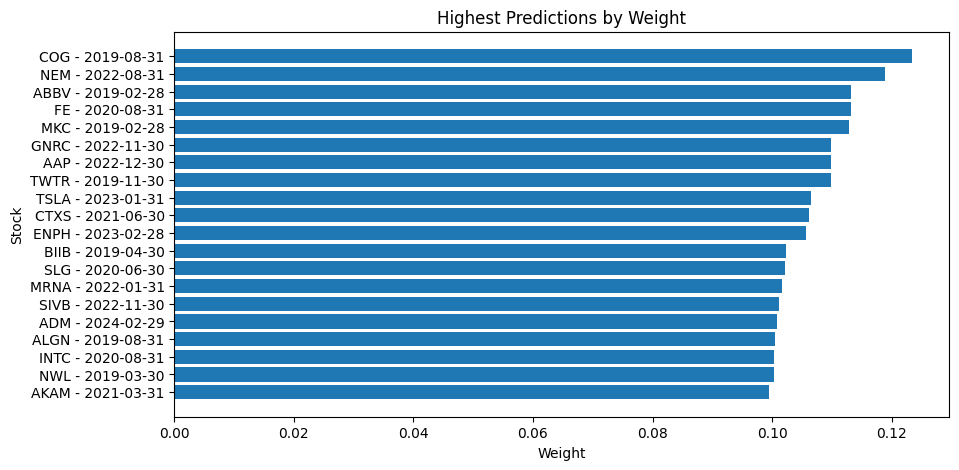

In [ ]:
weights = []
stocks  = []

for idx, row in monthly_history.iterrows():
    portfolio = eval(row["portfolio"])
    date = row["date_of_prediction"]
    for stock,weight in portfolio.items():
        if stock == "cash":
            continue
        stocks.append(f"{stock} - {str(date)[:10]}")
        weights.append(portfolio[stock])

portfolio_df = pd.DataFrame({"Stock": stocks, "Weight": weights})
portfolio_df = portfolio_df.sort_values("Weight", ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(portfolio_df.head(20)["Stock"], portfolio_df.head(20)["Weight"])
plt.title("Highest Predictions by Weight")
plt.xlabel("Weight")
plt.ylabel("Stock")
plt.gca().invert_yaxis() 
plt.show()

In [26]:

# accuracy_df = pd.DataFrame()
# accuracy_df["Top_K"] = [i for i in range(1, 11,2)]+ [i for i in range(10, 55, 5)]

# # for model_name in ["A3TGCN2_1", "A3TGCN2_2", "A3TGCN2_3", "A3TGCN2_4", "A3TGCN2_5", "A3TGCN2_6", "A3TGCN2_7", "LSTM_1", "LSTM_2", "LSTM_3", "LSTM_4"]:
# for model_name in ['A3TGCN2_5', 'A3TGCN2_6', 'A3TGCN2_7', 'LSTM_2', 'LSTM_3', 'LSTM_4']:
#     top_k_list = [x for x in accuracy_df["Top_K"]]
#     local_results = load_results(f"{model_name}_results")
#     accuracy_dict = prediction_accuracy(local_results, index_to_ticker, top_k=top_k_list, active_stocks_dict=active_stocks_dict, verbose=False)
#     accuracy_df[model_name] = accuracy_dict.values()

# accuracy_df.to_excel("../Data/Results/Top_K_Accuracy_Overall.xlsx", index=False)
# accuracy_df

accuracy_df = pd.read_excel("../Data/Results/Top_K_Accuracy_Overall.xlsx")
accuracy_df["Proportion of 1&2"] = 0.3506868
# accuracy_df = accuracy_df[['Top_K', 'Proportion of 1&2', 'A3TGCN2_1', 'A3TGCN2_2', 'A3TGCN2_3', 'A3TGCN2_4', 'A3TGCN2_5', 'A3TGCN2_6', 'A3TGCN2_7', 'LSTM_1', 'LSTM_2', 'LSTM_3', 'LSTM_4']]
accuracy_df = accuracy_df[['Top_K', 'Proportion of 1&2', 'A3TGCN2_5', 'A3TGCN2_6', 'A3TGCN2_7', 'LSTM_2', 'LSTM_3', 'LSTM_4']]
accuracy_df

,Top_K,Proportion of 1&2,A3TGCN2_5,A3TGCN2_6,A3TGCN2_7,LSTM_2,LSTM_3,LSTM_4
0,1,0.35068680,0.41121495,0.40452830,0.39856631,0.40944882,0.38912732,0.40300644
1,3,0.35068680,0.40546633,0.39555791,0.40577290,0.39833135,0.40038132,0.39866476
2,5,0.35068680,0.39544884,0.39444803,0.41070406,0.39882740,0.39705462,0.39030320
3,7,0.35068680,0.39865577,0.39814815,0.41304570,0.39601634,0.39944847,0.38624987
4,9,0.35068680,0.39743455,0.39331877,0.41074413,0.39275500,0.39733100,0.38468261
5,10,0.35068680,0.39700553,0.38980965,0.40958934,0.39200686,0.39748356,0.38333929
6,15,0.35068680,0.39344154,0.38570876,0.40369355,0.39271409,0.39405204,0.37906378
7,20,0.35068680,0.39096016,0.38419539,0.40216593,0.39042100,0.39327971,0.37834263
8,25,0.35068680,0.38944252,0.38249034,0.40245591,0.38786733,0.39309004,0.37826473
9,30,0.35068680,0.38771307,0.38140230,0.40391772,0.38709677,0.39368727,0.37914014


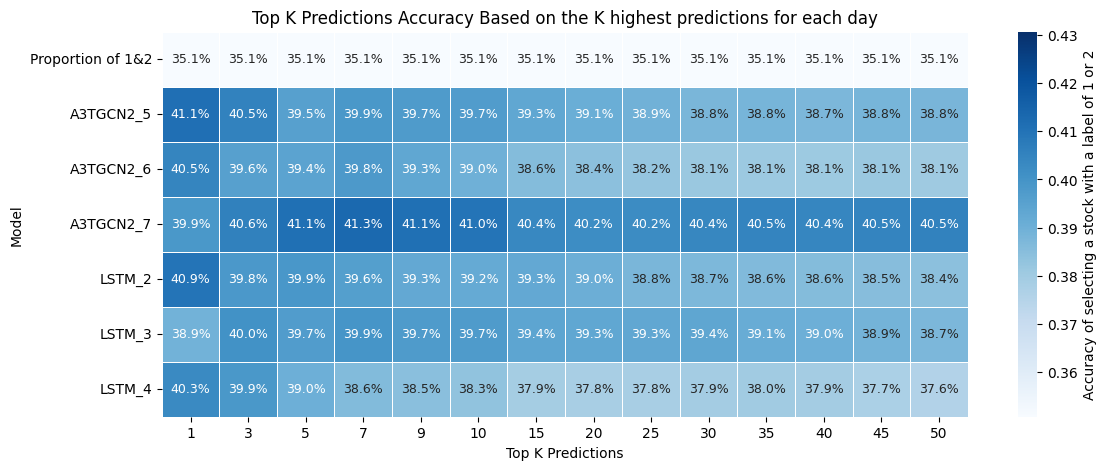

In [ ]:
plt.figure(figsize=(13, 5))

sns.heatmap(accuracy_df.set_index("Top_K").T, annot=True, fmt=".1%", cmap="Blues", linewidth=0.5, annot_kws={"size": 9}, 
                                                vmin=accuracy_df.loc[0,"Proportion of 1&2"], vmax=accuracy_df.loc[0,"Proportion of 1&2"]+0.08)
plt.ylabel("Model")
plt.xlabel("Top K Predictions")
plt.title("Top K Predictions Accuracy Based on the K highest predictions for each day")
cbar = plt.gca().collections[0].colorbar
cbar.set_label("Accuracy of selecting a stock with a label of 1 or 2")
plt.show()

In [ ]:
backtest_df = pd.read_excel(f"../Data/Results/Top_K_Backtesting_Overall.xlsx")
backtest_df
for col in backtest_df.columns:
    if "Top_K" in col:
        continue
    backtest_df[col] -= 100
    backtest_df[col] = backtest_df[col] / 100
    # backtest_df[col] = backtest_df[col].apply(lambda x: f"{x:.2f}%")

backtest_df["S&P 500"] = 1.38483

backtest_df["Mean at K"] = backtest_df[["A3TGCN2_1",	"A3TGCN2_2",	"A3TGCN2_3",	"A3TGCN2_4",	"A3TGCN2_5",	"A3TGCN2_6",	"A3TGCN2_7",	
                                    "LSTM_1",	"LSTM_2",	"LSTM_3",	"LSTM_4"]].mean(axis=1)


backtest_df.loc[14] = backtest_df.mean(axis=0)
backtest_df.loc[14,"Top_K"] = "Mean"


backtest_df

C:\Users\emilh\AppData\Local\Temp\ipykernel_17900\592988274.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mean' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  backtest_df.loc[14,"Top_K"] = "Mean"


,Top_K,A3TGCN2_1,A3TGCN2_2,A3TGCN2_3,A3TGCN2_4,A3TGCN2_5,A3TGCN2_6,A3TGCN2_7,LSTM_1,LSTM_2,LSTM_3,LSTM_4,S&P 500,Mean at K
0,1.00000000,-0.22555150,-0.23603407,-0.40497770,0.21815264,4.20133356,0.05517857,0.23149102,-0.40275475,-0.16237278,-0.22091877,0.87450377,1.38483000,0.35709545
1,3.00000000,-0.21658673,-0.45344759,0.28319960,0.30033065,0.90113890,0.88395088,1.23728846,0.04112993,0.81317630,0.30968541,0.27585137,1.38483000,0.39779247
2,5.00000000,0.35341094,0.19135001,0.19211261,0.66065264,0.48280669,1.06992607,0.81751135,0.33741487,0.74262863,0.97309879,0.66890148,1.38483000,0.58998310
3,7.00000000,0.30534599,0.20356111,0.75753756,1.17312199,0.91692589,1.43962799,0.54313479,0.63883303,1.37015703,0.82034393,0.77390437,1.38483000,0.81295397
4,9.00000000,0.40365567,0.29026153,0.95231582,1.34755645,1.04554639,1.52466566,0.76756778,0.91309075,1.47707203,0.90035358,0.96883224,1.38483000,0.96281072
5,10.00000000,0.48082315,0.35017239,0.81102148,1.22244185,1.24891599,1.79238262,1.03999225,0.94520428,1.41031522,0.92727547,1.26874473,1.38483000,1.04520813
6,15.00000000,0.65524596,0.51702588,1.16234423,1.25780510,1.59735193,1.64170719,1.17763165,1.02453421,1.40823251,0.80243155,1.92366886,1.38483000,1.19708901
7,20.00000000,0.85376239,0.69750813,1.18250390,1.03041264,1.78832414,1.73176464,1.44136982,1.14423496,1.47379105,0.85844629,1.79482731,1.38483000,1.27244957
8,25.00000000,0.89270329,0.97999846,1.35418369,1.08838708,1.90935954,1.56923203,1.42597983,1.17369936,1.36557847,0.82910795,1.51795649,1.38483000,1.28238056
9,30.00000000,0.98962184,1.00339982,1.47535301,1.27556945,1.77621670,1.61389509,1.24999074,1.19101983,1.38127690,1.06685838,1.75546545,1.38483000,1.34351520


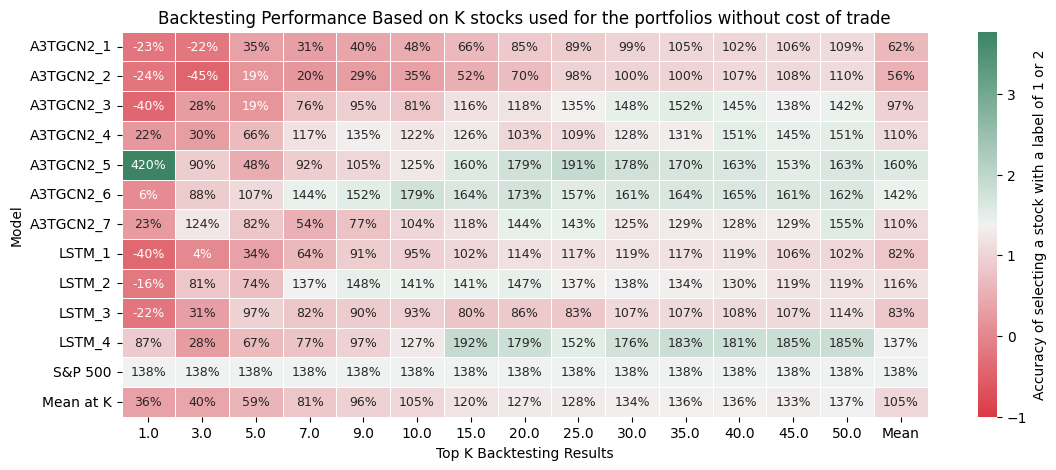

In [ ]:
plt.figure(figsize=(13, 5))
cmap = sns.diverging_palette(10, 150, as_cmap=True)

sns.heatmap(backtest_df.set_index("Top_K").T, annot=True, fmt=".0%", cmap=cmap, linewidth=0.5, annot_kws={"size": 9}, 
                                                vmin=-1, vmax=1.38483*2+1)
                                                # vmin=0, vmax=1.38483*2)  
plt.ylabel("Model")
plt.xlabel("Top K Backtesting Results")
plt.title("Backtesting Performance Based on K stocks used for the portfolios without cost of trade")
cbar = plt.gca().collections[0].colorbar
cbar.set_label("Accuracy of selecting a stock with a label of 1 or 2")

plt.show()


In [ ]:
backtest_df = pd.read_excel(f"../Data/Results/Top_K_Backtesting_Overall_with_cost.xlsx")
backtest_df
for col in backtest_df.columns:
    if "Top_K" in col:
        continue
    backtest_df[col] -= 100
    backtest_df[col] = backtest_df[col] / 100
    # backtest_df[col] = backtest_df[col].apply(lambda x: f"{x:.2f}%")

backtest_df["S&P 500"] = 1.38483
backtest_df["Mean at K"] = backtest_df[["A3TGCN2_1",	"A3TGCN2_2",	"A3TGCN2_3",	"A3TGCN2_4",	"A3TGCN2_5",	"A3TGCN2_6",	"A3TGCN2_7",	
                                    "LSTM_1",	"LSTM_2",	"LSTM_3",	"LSTM_4"]].mean(axis=1)

backtest_df.loc[14] = backtest_df.mean(axis=0)
backtest_df.loc[14,"Top_K"] = "Mean"

backtest_df

C:\Users\emilh\AppData\Local\Temp\ipykernel_17900\2272145218.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mean' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  backtest_df.loc[14,"Top_K"] = "Mean"


,Top_K,A3TGCN2_1,A3TGCN2_2,A3TGCN2_3,A3TGCN2_4,A3TGCN2_5,A3TGCN2_6,A3TGCN2_7,LSTM_1,LSTM_2,LSTM_3,LSTM_4,S&P 500,Mean at K
0,1.00000000,-0.26536933,-0.27542460,-0.43577350,0.15531418,3.93346688,0.00077500,0.16819236,-0.42573465,-0.19467582,-0.25083239,0.80215168,1.38483000,0.29200816
1,3.00000000,-0.25670306,-0.48138341,0.21787579,0.23427823,0.80698662,0.78722147,1.12252319,0.00090728,0.74328365,0.25923794,0.22667426,1.38483000,0.33280927
2,5.00000000,0.28433734,0.13034768,0.13229409,0.57603316,0.41048070,0.96480307,0.72417537,0.28578816,0.67552212,0.89707969,0.60461602,1.38483000,0.51686158
3,7.00000000,0.23903611,0.14226910,0.66921143,1.06276529,0.82491448,1.31602976,0.46386187,0.57566121,1.27892674,0.75021606,0.70549779,1.38483000,0.72985362
4,9.00000000,0.33238324,0.22459825,0.85382607,1.22861456,0.94826162,1.39693451,0.67673489,0.83942091,1.38170598,0.82730661,0.89288733,1.38483000,0.87297036
5,10.00000000,0.40577572,0.28147451,0.71964252,1.11037139,1.14331205,1.65117127,0.93515151,0.87029494,1.31752643,0.85318207,1.18126499,1.38483000,0.95174249
6,15.00000000,0.57211231,0.44022662,1.05362686,1.14415508,1.47563071,1.50829466,1.06628042,0.94656099,1.31550864,0.73311935,1.81091246,1.38483000,1.09694801
7,20.00000000,0.76083893,0.61185482,1.07361610,0.92972658,1.66039750,1.59533885,1.31773307,1.06169110,1.37856378,0.78698525,1.68711026,1.38483000,1.16944148
8,25.00000000,0.79823224,0.88043472,1.23797996,0.98590262,1.77869892,1.44209397,1.30463261,1.09002142,1.27454668,0.75880199,1.42102010,1.38483000,1.17930593
9,30.00000000,0.89049706,0.90323656,1.35410924,1.16516606,1.65426969,1.48552195,1.13876038,1.10668819,1.28970953,0.98740104,1.64951489,1.38483000,1.23862496


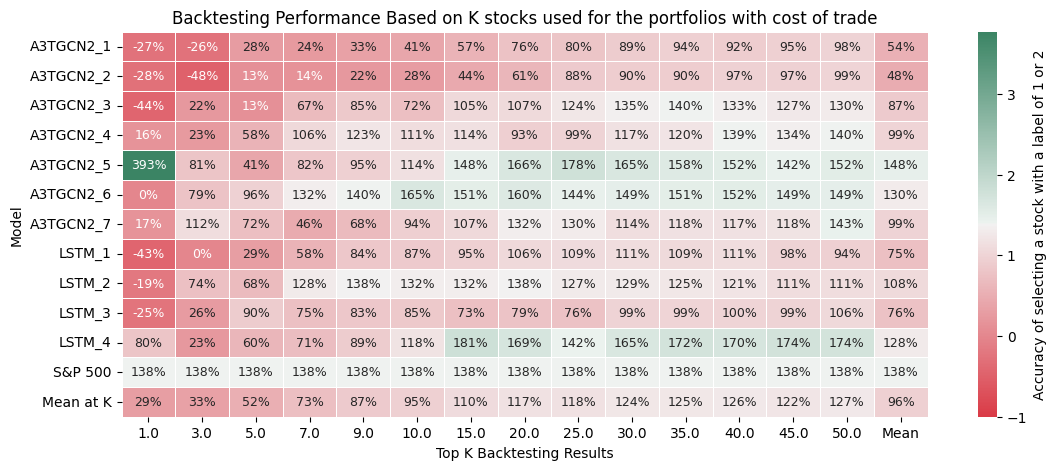

In [ ]:
plt.figure(figsize=(13, 5))
cmap = sns.diverging_palette(10, 150, as_cmap=True)

sns.heatmap(backtest_df.set_index("Top_K").T, annot=True, fmt=".0%", cmap=cmap, linewidth=0.5, annot_kws={"size": 9}, 
                                                # vmin=-1, vmax=1.38483)
                                                vmin=-1, vmax=1.38483*2+1)
plt.ylabel("Model")
plt.xlabel("Top K Backtesting Results")
plt.title("Backtesting Performance Based on K stocks used for the portfolios with cost of trade")
cbar = plt.gca().collections[0].colorbar
cbar.set_label("Accuracy of selecting a stock with a label of 1 or 2")
plt.show()


# Investigating the monthly results of the backtester to understand if the results align with the stock prices.

In [ ]:
monthly_history.sort_values(by="net_value_%_increase", ascending=False).head(5)

,date_of_prediction,start_date,end_date,net_value,amount_of_stocks,cash_holding,portfolio,individual_ticker_pct_change,net_value_%_increase
15,2020-03-31,2020-04-01,2020-04-30,123.96954315,15,0,"{'ALGN': 0.05941257870370806, 'CPRI': 0.070627...","[{'ALGN': {'pct_change': 0.18045971703234412, ...",35.97595627
59,2023-11-30,2023-12-01,2023-12-29,305.41584393,15,0,"{'ALGN': 0.07607768885251423, 'BIO': 0.0757924...","[{'ALGN': {'pct_change': 0.3007051999388893, '...",18.38083224
48,2022-12-30,2023-01-01,2023-01-31,309.72759985,15,0,"{'AAP': 0.10993163229729923, 'ADSK': 0.0578453...","[{'AAP': {'pct_change': 0.029934026104421564, ...",15.90179205
42,2022-06-30,2022-07-01,2022-07-31,236.44618899,15,0,"{'ANET': 0.05453338397539249, 'BBWI': 0.063477...","[{'ANET': {'pct_change': 0.2301206873057271, '...",15.46973999
17,2020-05-30,2020-06-01,2020-06-30,143.17202732,15,0,"{'AAL': 0.0784272052029818, 'AJG': 0.059983973...","[{'AAL': {'pct_change': 0.3949375533852114, 's...",14.16609020
